In [ ]:
import re
import numpy as np
import pandas as pd
import os, glob, re
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import scipy.signal as signal
from scipy.io import savemat
import zipfile
from google.colab import files



from sklearn.model_selection import StratifiedGroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, f1_score


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base = "/content/drive/MyDrive/CAL_CSV"
et_dir = os.path.join(base, "ET")
pd_dir = os.path.join(base, "PD")

def load_numeric(dir_path):
    files = glob.glob(os.path.join(dir_path, "*.csv"))
    pairs = []
    for p in files:
        name = os.path.splitext(os.path.basename(p))[0]
        m = re.search(r"\d+", name)
        if m:
            pairs.append((int(m.group()), p))
    pairs.sort(key=lambda x: x[0])

    idx = [i for i, _ in pairs]
    dfs = [pd.read_csv(p) for _, p in pairs]

    if idx and idx != list(range(min(idx), max(idx) + 1)):
        missing = sorted(set(range(min(idx), max(idx) + 1)) - set(idx))
        print("Missing indices:", missing)

    return dfs, idx

df_et, et_idx = load_numeric(et_dir)
df_pd, pd_idx = load_numeric(pd_dir)

print("ET:", len(df_et), "files", "min/max:", (min(et_idx), max(et_idx)) if et_idx else None)
print("PD:", len(df_pd), "files", "min/max:", (min(pd_idx), max(pd_idx)) if pd_idx else None)






#!!!!!!!!!!! УДАЛИТЬ ИНДЕКСЫ
drop_et = { }
drop_pd = { 3 }

keep_et_mask = [i not in drop_et for i in et_idx]
df_et  = [d for d, m in zip(df_et, keep_et_mask) if m]
et_idx = [i for i, m in zip(et_idx, keep_et_mask) if m]

keep_pd_mask = [i not in drop_pd for i in pd_idx]
df_pd  = [d for d, m in zip(df_pd, keep_pd_mask) if m]
pd_idx = [i for i, m in zip(pd_idx, keep_pd_mask) if m]

print("AFTER DROP -> ET:", len(df_et), "indices:", et_idx)
print("AFTER DROP -> PD:", len(df_pd), "indices:", pd_idx)


Missing indices: [2, 4]
Missing indices: [4, 7, 8, 9, 10, 14, 15]
ET: 8 files min/max: (0, 9)
PD: 10 files min/max: (0, 16)
AFTER DROP -> ET: 8 indices: [0, 1, 3, 5, 6, 7, 8, 9]
AFTER DROP -> PD: 9 indices: [0, 1, 2, 5, 6, 11, 12, 13, 16]


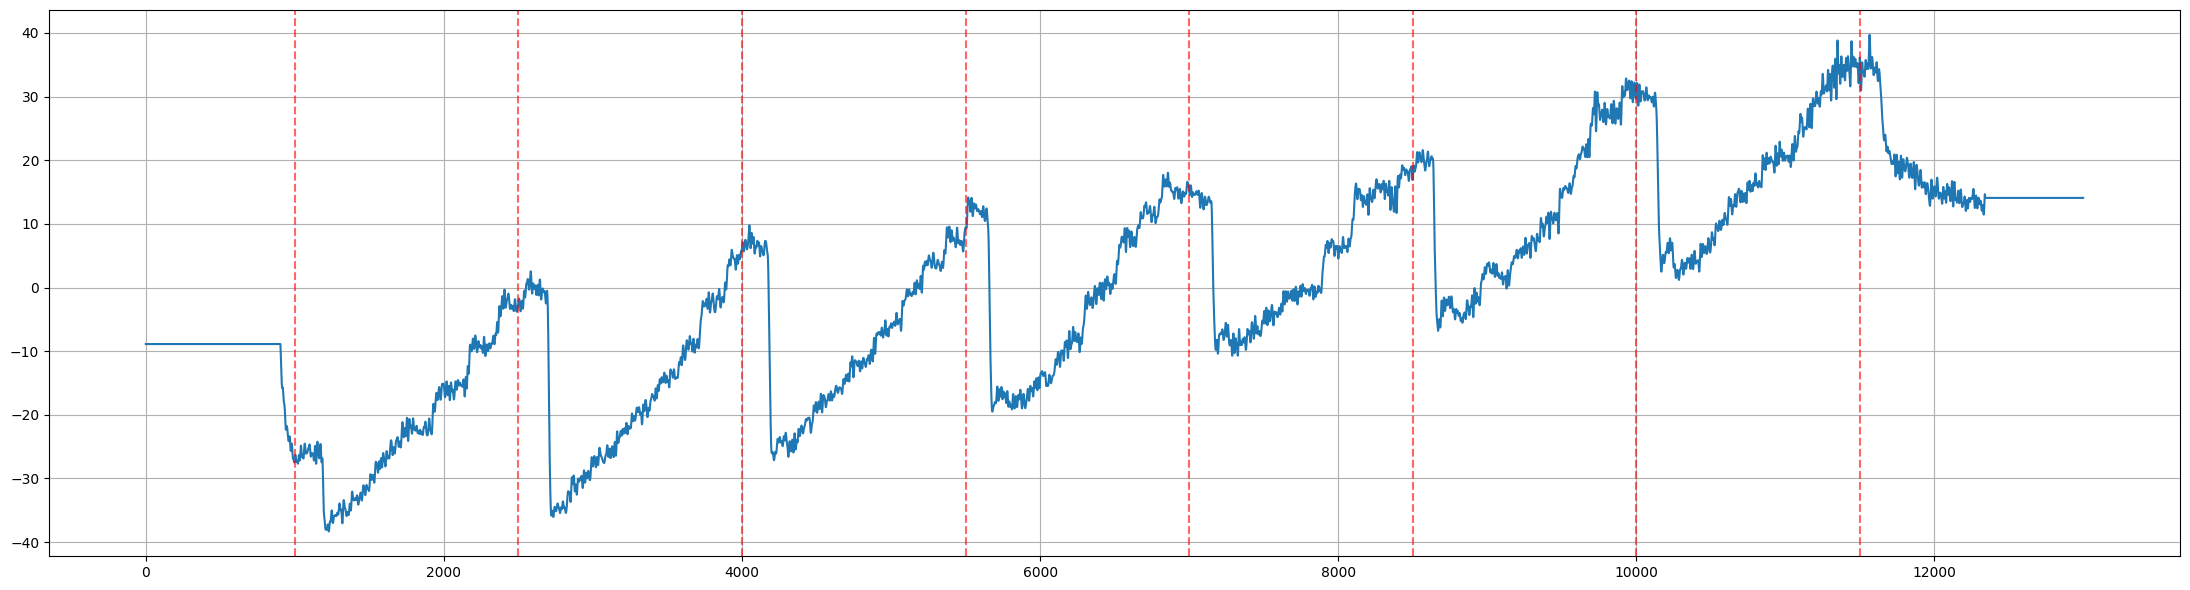

In [ ]:
impulses = [1000, 2500, 4000, 5500, 7000, 8500, 10000, 11500]

s = df_pd[1]["EOG_left_v"].to_numpy()

plt.figure(figsize=(22, 6))
plt.plot(s)

for x in impulses:
    plt.axvline(x, linestyle="--", alpha=0.6, color="red")

plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
from scipy.signal import butter, filtfilt

EOG_COLS = ["EOG_left_h", "EOG_right_h", "EOG_left_v", "EOG_right_v"]

def interp_bad(x):
    x = np.asarray(x, dtype=float)
    n = x.size
    good = np.isfinite(x)
    if good.all():
        return x
    if not good.any():
        return np.zeros(n, dtype=float)
    xi = np.arange(n)
    x2 = x.copy()
    x2[~good] = np.interp(xi[~good], xi[good], x[good])
    return x2

def butter_bandpass_filtfilt(x, fs, low=0.1, high=35.0, order=4):
    nyq = fs / 2.0
    low_n = low / nyq
    high_n = high / nyq
    b, a = butter(order, [low_n, high_n], btype="bandpass")
    try:
        return filtfilt(b, a, x)
    except ValueError:
        return x

def preprocess_simple(df, fs=500, low=0.1, high=35.0, order=4, baseline_n=1000):
    df = df.copy()
    for col in EOG_COLS:
        if col not in df.columns:
            continue

        x = pd.to_numeric(df[col], errors="coerce").to_numpy(dtype=float)
        x = interp_bad(x)

        n0 = min(baseline_n, len(x))
        base = np.median(x[:n0]) if n0 > 0 else 0.0
        x = x - base

        x = butter_bandpass_filtfilt(x, fs=fs, low=low, high=high, order=order)

        x = x - np.median(x)

        df[col] = x

    return df

fs = 500
df_et = [preprocess_simple(d, fs=fs, low=0.03, high=45.0, order=3, baseline_n=1000) for d in df_et]
df_pd = [preprocess_simple(d, fs=fs, low=0.03, high=45.0, order=3, baseline_n=1000) for d in df_pd]


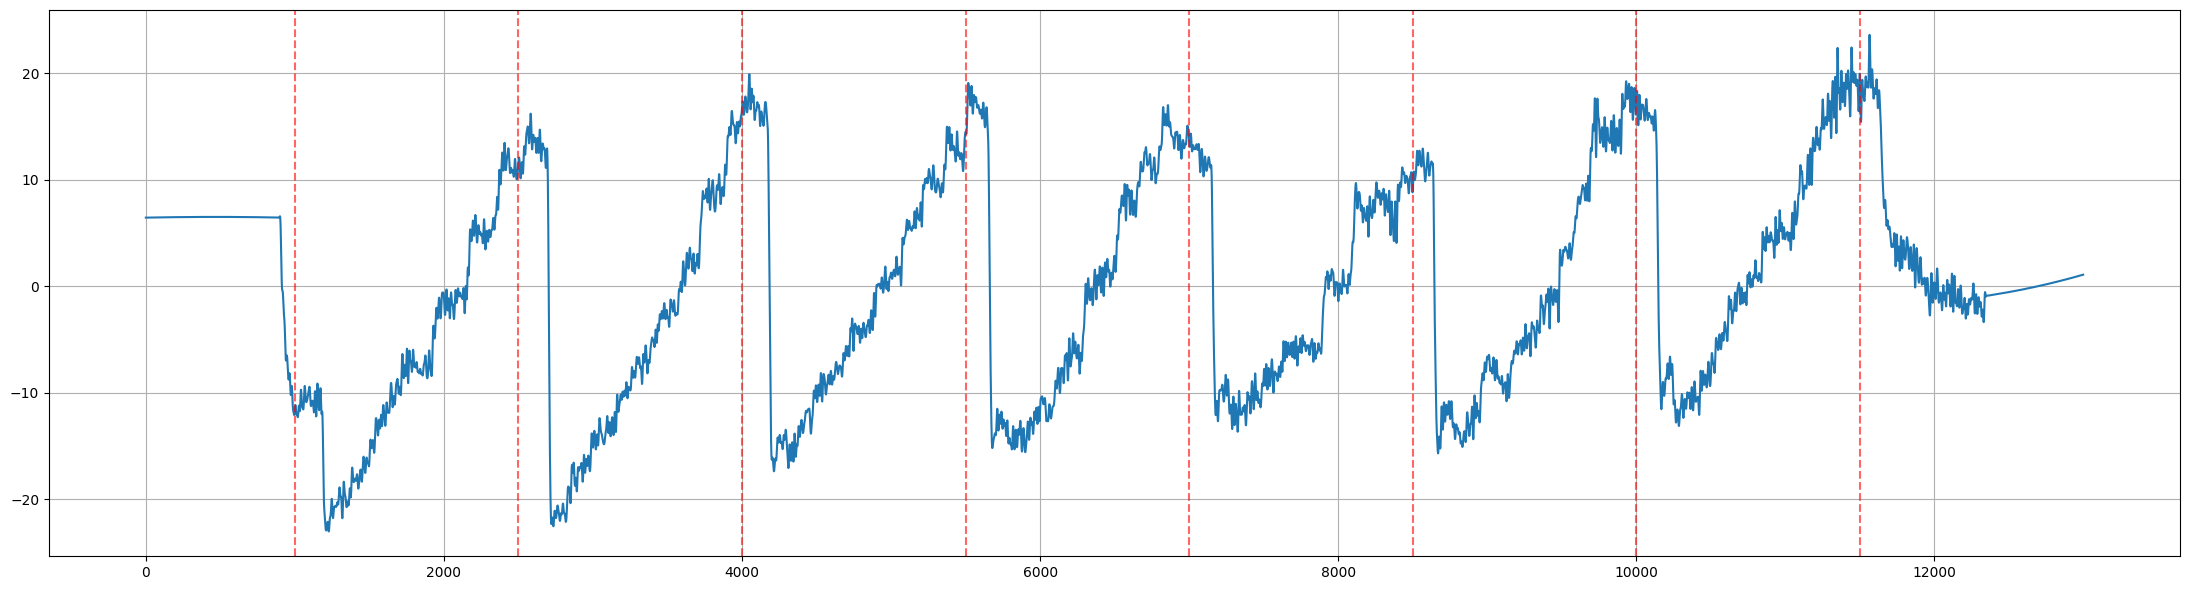

In [ ]:
impulses = [1000, 2500, 4000, 5500, 7000, 8500, 10000, 11500]

s = df_pd[1]["EOG_left_v"].to_numpy()

plt.figure(figsize=(22, 6))
plt.plot(s)

for x in impulses:
    plt.axvline(x, linestyle="--", alpha=0.6, color="red")

plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
try:
    import pywt
except ImportError:
    !pip -q install PyWavelets
    import pywt

wavelet = "db33"
desired_level = 6
thr_k = 6.0

CROP_A = 1000
CROP_B = 11500
CHANNEL = "EOG_left_v"

def crop_1000_11500(x, a=CROP_A, b=CROP_B):
    x = np.asarray(x, dtype=float)
    need = b + 1

    if x.size < need:
        if x.size == 0:
            x = np.zeros(need, dtype=float)
        else:
            pad_val = np.nanmedian(x)
            if not np.isfinite(pad_val):
                finite = x[np.isfinite(x)]
                pad_val = float(finite[0]) if finite.size else 0.0
            x = np.pad(x, (0, need - x.size), mode="constant", constant_values=pad_val)

    return x[a:b+1]

def mad(x):
    x = np.asarray(x, float)
    med = np.median(x)
    return np.median(np.abs(x - med)) + 1e-12

def wavelet_features(sig, wavelet=wavelet, desired_level=desired_level, thr_k=thr_k):
    y = np.asarray(sig, dtype=float)
    y = y[np.isfinite(y)]
    if len(y) < 16:
        return np.zeros(desired_level + 1 + 2, dtype=float)

    w = pywt.Wavelet(wavelet)
    max_level = pywt.dwt_max_level(len(y), w.dec_len)
    L = min(desired_level, max_level)

    coeffs = pywt.wavedec(y, wavelet, level=L, mode="symmetric")
    energies = np.array([np.sum(c*c) for c in coeffs], dtype=float)
    total = energies.sum() + 1e-12
    energies = energies / total

    E = np.zeros(desired_level + 1, dtype=float)
    E[-(L+1):] = energies

    sharp_count = 0.0
    sharp_max = 0.0
    if L >= 1:
        cD1 = coeffs[-1]
        s = mad(cD1)
        z = np.abs(cD1) / s
        sharp_count = float(np.sum(z > thr_k))
        sharp_max = float(np.max(z)) if z.size else 0.0

    return np.concatenate([E, [sharp_count, sharp_max]])

et_full = [crop_1000_11500(d[CHANNEL].to_numpy()) for d in df_et]
pd_full = [crop_1000_11500(d[CHANNEL].to_numpy()) for d in df_pd]

rows = []
for pi, sig in enumerate(et_full):
    feat = wavelet_features(sig)
    rows.append(("ET", pi, *feat))

for pi, sig in enumerate(pd_full):
    feat = wavelet_features(sig)
    rows.append(("PD", pi, *feat))

feat_cols = (
    [f"E_{wavelet}_A_L{desired_level}"] +
    [f"E_{wavelet}_D_L{k}" for k in range(desired_level, 0, -1)] +
    ["sharp_count_cD1", "sharp_max_cD1"]
)

df_feat = pd.DataFrame(rows, columns=["group", "patient_i", *feat_cols])
df_feat


,group,patient_i,E_db33_A_L6,E_db33_D_L6,E_db33_D_L5,E_db33_D_L4,E_db33_D_L3,E_db33_D_L2,E_db33_D_L1,sharp_count_cD1,sharp_max_cD1
0,ET,0,0.990588,0.008685,0.000651,0.000066,0.000011,3.924900e-09,1.323382e-10,304.0,6.600787e+06
1,ET,1,0.992504,0.006060,0.000660,0.000567,0.000209,1.473259e-08,9.655982e-11,53.0,1.195869e+05
2,ET,2,0.991029,0.006778,0.001572,0.000461,0.000160,5.894246e-09,3.799633e-11,43.0,1.079227e+05
3,ET,3,0.993352,0.005475,0.001056,0.000102,0.000015,1.925485e-08,2.351669e-10,47.0,4.231262e+05
4,ET,4,0.940793,0.042179,0.016248,0.000581,0.000198,1.912792e-07,5.485879e-09,47.0,1.247465e+06
5,ET,5,0.937211,0.052422,0.008179,0.001801,0.000387,5.241325e-07,1.672139e-09,45.0,9.321387e+05
6,ET,6,0.880226,0.109527,0.009727,0.000471,0.000048,8.994627e-07,4.035252e-08,46.0,3.293965e+06
7,ET,7,0.987316,0.008231,0.002331,0.001746,0.000376,3.613716e-08,1.654400e-10,41.0,6.499214e+04
8,PD,0,0.936817,0.050986,0.010916,0.001060,0.000221,9.125225e-08,1.224146e-09,45.0,2.899652e+05
9,PD,1,0.982395,0.011831,0.003070,0.002043,0.000661,3.635795e-07,4.955351e-09,49.0,8.285538e+05


In [ ]:
from scipy.stats import brunnermunzel, mannwhitneyu

df = df_feat.copy()

id_cols = ["group", "patient_i"]
feat_cols = [c for c in df.columns if c not in id_cols]

pat_df = (
    df.groupby(["group", "patient_i"], as_index=False)[feat_cols]
      .mean(numeric_only=True)
)

def compare_pd_et_tests(pat_df, group_col="group", pd_label="PD", et_label="ET"):
    feat_cols = [c for c in pat_df.columns if c not in [group_col, "patient_i"]]

    rows = []
    for feat in feat_cols:
        x_et = pat_df.loc[pat_df[group_col] == et_label, feat].dropna().to_numpy()
        x_pd = pat_df.loc[pat_df[group_col] == pd_label, feat].dropna().to_numpy()

        row = {"feature": feat, "nET": len(x_et), "nPD": len(x_pd)}

        if len(x_et) < 2 or len(x_pd) < 2:
            row.update({"bm_stat": np.nan, "bm_p": np.nan, "mwu_stat": np.nan, "mwu_p": np.nan})
            rows.append(row)
            continue

        if np.allclose(x_et, x_et[0]) and np.allclose(x_pd, x_pd[0]) and np.isclose(x_et[0], x_pd[0]):
            row.update({"bm_stat": 0.0, "bm_p": 1.0, "mwu_stat": np.nan, "mwu_p": 1.0})
            rows.append(row)
            continue

        try:
            bm = brunnermunzel(x_pd, x_et, alternative="two-sided")
            row["bm_stat"] = float(bm.statistic)
            row["bm_p"] = float(bm.pvalue)
        except Exception:
            row["bm_stat"] = np.nan
            row["bm_p"] = np.nan

        try:
            mwu = mannwhitneyu(x_pd, x_et, alternative="two-sided", method="auto")
            row["mwu_stat"] = float(mwu.statistic)
            row["mwu_p"] = float(mwu.pvalue)
        except Exception:
            row["mwu_stat"] = np.nan
            row["mwu_p"] = np.nan

        rows.append(row)

    res = pd.DataFrame(rows).sort_values(["bm_p", "mwu_p"], na_position="last")
    return res

res_tests = compare_pd_et_tests(pat_df)

print("Patient-level table shape:", pat_df.shape)
display(pat_df.head())

print("Tests table shape:", res_tests.shape)
display(res_tests)


Patient-level table shape: (17, 11)


,group,patient_i,E_db33_A_L6,E_db33_D_L6,E_db33_D_L5,E_db33_D_L4,E_db33_D_L3,E_db33_D_L2,E_db33_D_L1,sharp_count_cD1,sharp_max_cD1
0,ET,0,0.990588,0.008685,0.000651,0.000066,0.000011,3.924900e-09,1.323382e-10,304.0,6.600787e+06
1,ET,1,0.992504,0.006060,0.000660,0.000567,0.000209,1.473259e-08,9.655982e-11,53.0,1.195869e+05
2,ET,2,0.991029,0.006778,0.001572,0.000461,0.000160,5.894246e-09,3.799633e-11,43.0,1.079227e+05
3,ET,3,0.993352,0.005475,0.001056,0.000102,0.000015,1.925485e-08,2.351669e-10,47.0,4.231262e+05
4,ET,4,0.940793,0.042179,0.016248,0.000581,0.000198,1.912792e-07,5.485879e-09,47.0,1.247465e+06


Tests table shape: (9, 7)


,feature,nET,nPD,bm_stat,bm_p,mwu_stat,mwu_p
4,E_db33_D_L3,8,9,-2.407734,0.032703,57.0,0.046401
3,E_db33_D_L4,8,9,-2.306227,0.049348,58.0,0.035952
5,E_db33_D_L2,8,9,-1.277169,0.224885,49.0,0.235870
6,E_db33_D_L1,8,9,-1.175932,0.271688,49.0,0.235870
0,E_db33_A_L6,8,9,1.114741,0.298290,23.0,0.235870
1,E_db33_D_L6,8,9,-0.930263,0.380633,47.0,0.321267
2,E_db33_D_L5,8,9,-0.887641,0.402753,47.0,0.321267
8,sharp_max_cD1,8,9,0.645576,0.529746,29.0,0.541423
7,sharp_count_cD1,8,9,0.617873,0.546195,29.5,0.558845


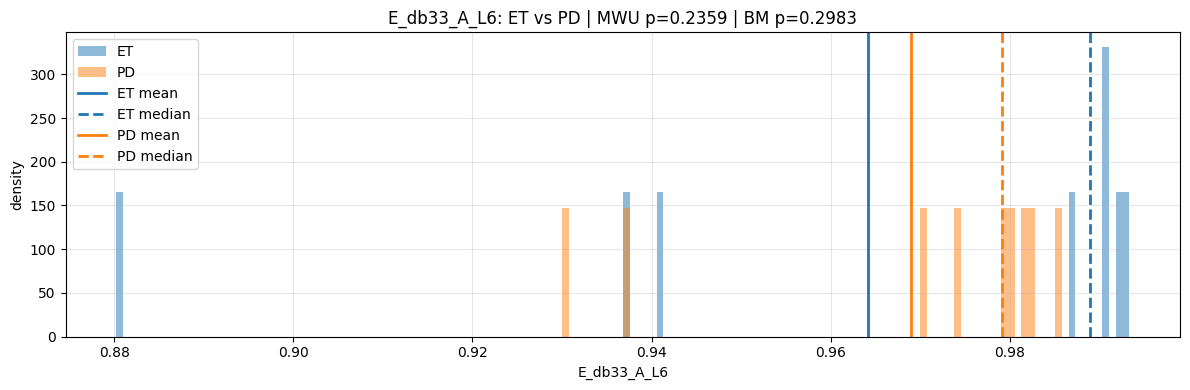

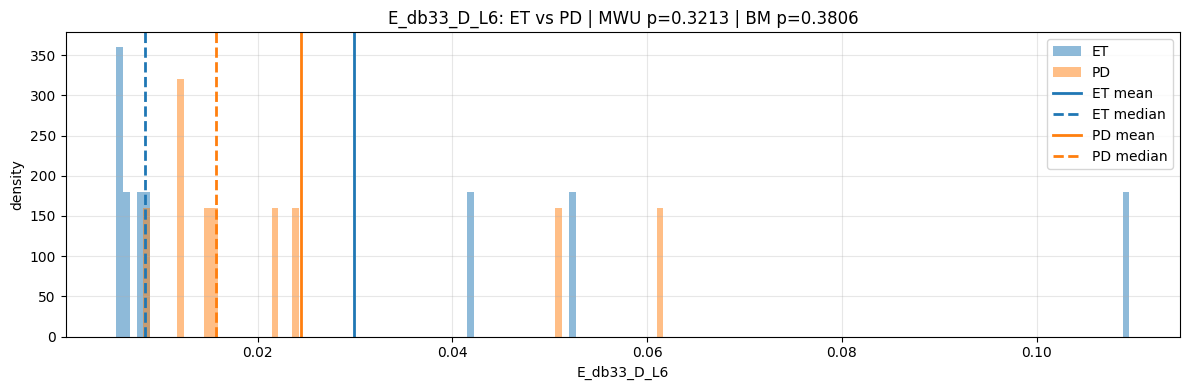

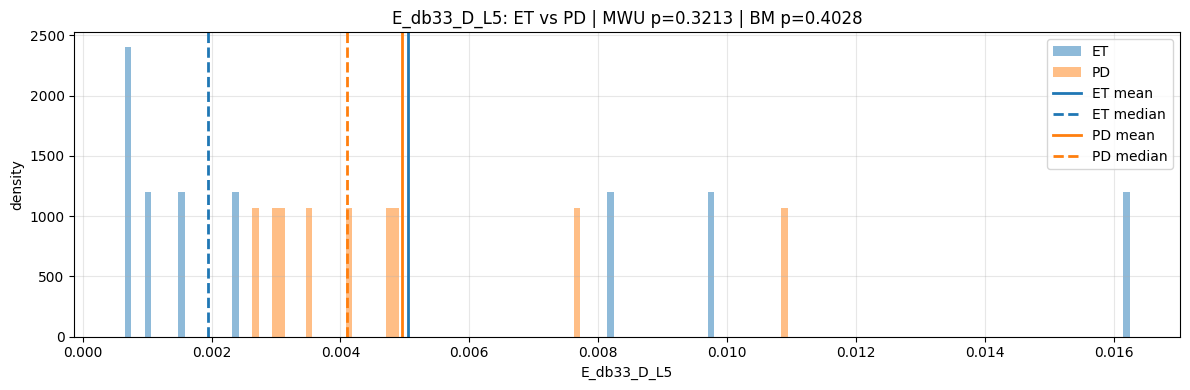

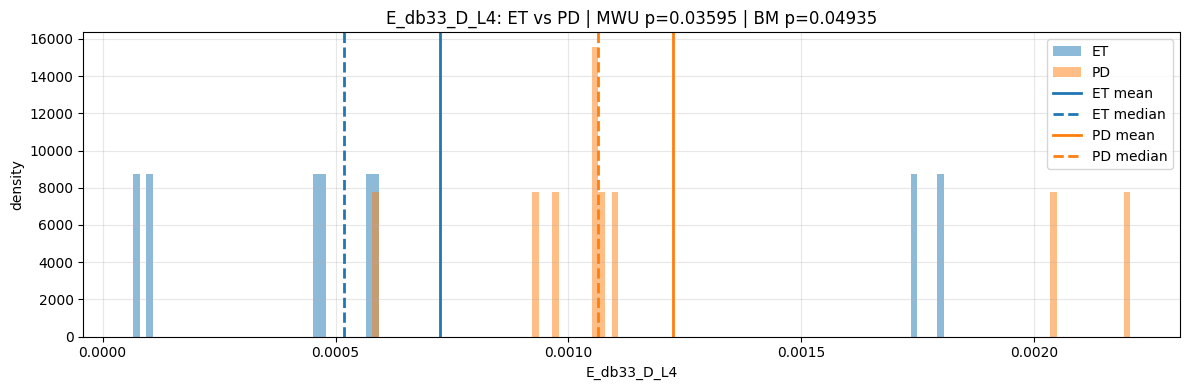

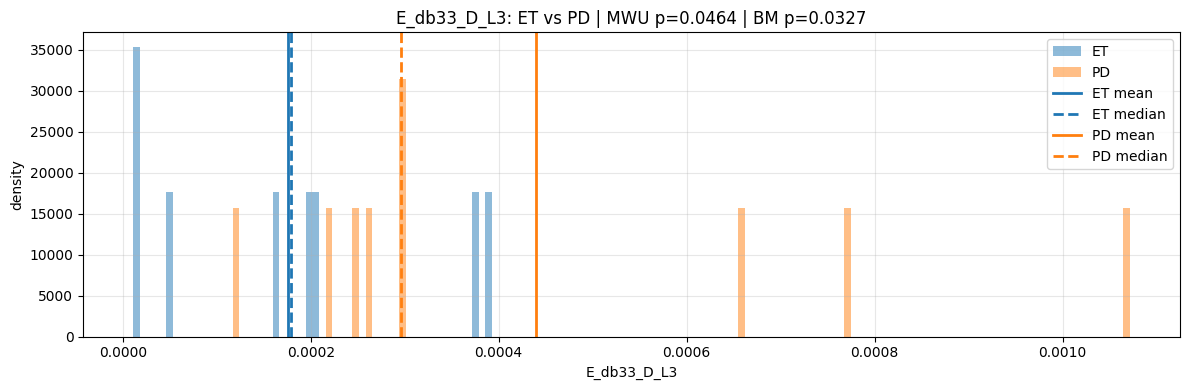

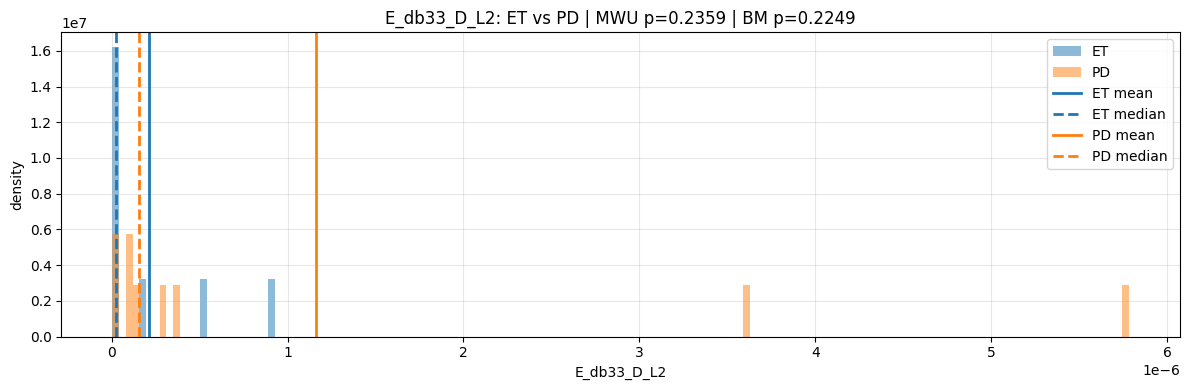

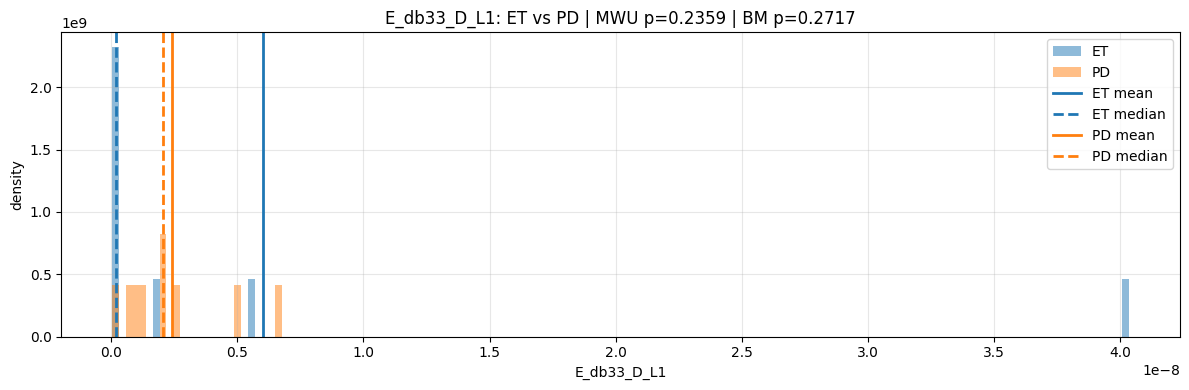

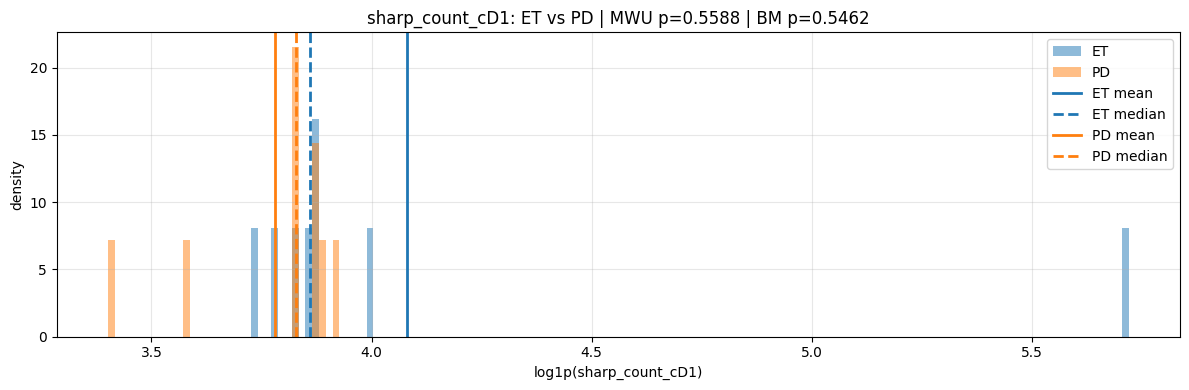

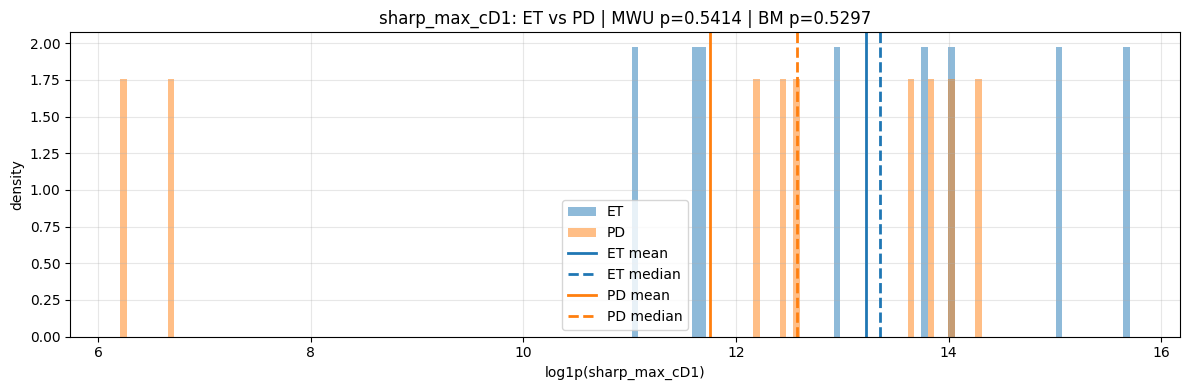

,feature,n_ET,n_PD,ET_mean,ET_median,PD_mean,PD_median,MWU_p,BM_p
0,E_db33_D_L4,8,9,7.244517e-04,5.192876e-04,1.225143e-03,1.062856e-03,0.035952,0.049348
1,E_db33_D_L3,8,9,1.754067e-04,1.786955e-04,4.392733e-04,2.963454e-04,0.046401,0.032703
2,E_db33_D_L2,8,9,2.118523e-07,2.769600e-08,1.161474e-06,1.579117e-07,0.235870,0.224885
3,E_db33_D_L1,8,9,6.022255e-09,2.003034e-10,2.409288e-09,2.052134e-09,0.235870,0.271688
4,E_db33_A_L6,8,9,9.641274e-01,9.889519e-01,9.689273e-01,9.791676e-01,0.235870,0.298290
5,E_db33_D_L6,8,9,2.991954e-02,8.457867e-03,2.445979e-02,1.574006e-02,0.321267,0.380633
6,E_db33_D_L5,8,9,5.053007e-03,1.951801e-03,4.947332e-03,4.098398e-03,0.321267,0.402753


In [ ]:
feature_cols = [c for c in df_feat.columns if c not in ["group", "patient_i"]]

rows = []

for col in feature_cols:
    et = df_feat.loc[df_feat["group"] == "ET", col].astype(float).to_numpy()
    pd_ = df_feat.loc[df_feat["group"] == "PD", col].astype(float).to_numpy()

    et = et[np.isfinite(et)]
    pd_ = pd_[np.isfinite(pd_)]

    if col.startswith("sharp"):
        et_plot = np.log1p(et)
        pd_plot = np.log1p(pd_)
        xlabel = f"log1p({col})"
    else:
        et_plot = et
        pd_plot = pd_
        xlabel = col

    et_mean = float(np.mean(et_plot)) if len(et_plot) else np.nan
    et_med  = float(np.median(et_plot)) if len(et_plot) else np.nan
    pd_mean = float(np.mean(pd_plot)) if len(pd_plot) else np.nan
    pd_med  = float(np.median(pd_plot)) if len(pd_plot) else np.nan

    mwu_p = np.nan
    bm_p  = np.nan
    if len(et_plot) and len(pd_plot):
        try:
            mwu_p = float(mannwhitneyu(et_plot, pd_plot, alternative="two-sided").pvalue)
        except Exception:
            mwu_p = np.nan
        try:
            bm_p = float(brunnermunzel(et_plot, pd_plot, alternative="two-sided").pvalue)
        except Exception:
            bm_p = np.nan

    if len(et_plot) and len(pd_plot):
        all_vals = np.concatenate([et_plot, pd_plot])
    else:
        all_vals = et_plot if len(et_plot) else pd_plot

    if len(all_vals) == 0:
        continue

    bins = np.histogram_bin_edges(all_vals, bins=150)

    # plot
    plt.figure(figsize=(12, 4))
    plt.hist(et_plot, bins=bins, density=True, alpha=0.5, label="ET", color="C0")
    plt.hist(pd_plot, bins=bins, density=True, alpha=0.5, label="PD", color="C1")

    if np.isfinite(et_mean): plt.axvline(et_mean, color="C0", linestyle="-",  linewidth=2, label="ET mean")
    if np.isfinite(et_med):  plt.axvline(et_med,  color="C0", linestyle="--", linewidth=2, label="ET median")
    if np.isfinite(pd_mean): plt.axvline(pd_mean, color="C1", linestyle="-",  linewidth=2, label="PD mean")
    if np.isfinite(pd_med):  plt.axvline(pd_med,  color="C1", linestyle="--", linewidth=2, label="PD median")

    plt.title(f"{col}: ET vs PD | MWU p={mwu_p:.4g} | BM p={bm_p:.4g}")
    plt.xlabel(xlabel)
    plt.ylabel("density")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    rows.append({
        "feature": col,
        "n_ET": int(len(et_plot)),
        "n_PD": int(len(pd_plot)),
        "ET_mean": et_mean,
        "ET_median": et_med,
        "PD_mean": pd_mean,
        "PD_median": pd_med,
        "MWU_p": mwu_p,
        "BM_p": bm_p,
    })

res_df = pd.DataFrame(rows).sort_values(["MWU_p", "BM_p"], na_position="last").reset_index(drop=True)
res_df = (
    pd.DataFrame(rows)
      .sort_values(["MWU_p", "BM_p"], na_position="last")
      .query("feature not in ['sharp_max_cD1', 'sharp_count_cD1']")
      .reset_index(drop=True)
)

res_df



In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu, brunnermunzel

def pvals(df, feat):
    et = df.loc[df["group"]=="ET", feat].to_numpy(float)
    pd_ = df.loc[df["group"]=="PD", feat].to_numpy(float)
    et = et[np.isfinite(et)]
    pd_ = pd_[np.isfinite(pd_)]
    if len(et) < 2 or len(pd_) < 2:
        return np.nan, np.nan
    return (float(mannwhitneyu(et, pd_, alternative="two-sided").pvalue),
            float(brunnermunzel(et, pd_, alternative="two-sided").pvalue))

def loo_table(pat_df, feat):
    base_mwu, base_bm = pvals(pat_df, feat)
    rows = [{"drop": "none", "MWU_p": base_mwu, "BM_p": base_bm}]
    for g in ["ET","PD"]:
        for pid in pat_df.loc[pat_df["group"]==g, "patient_i"].unique():
            df2 = pat_df[~((pat_df["group"]==g) & (pat_df["patient_i"]==pid))]
            mwu_p, bm_p = pvals(df2, feat)
            rows.append({"drop": f"{g}:{int(pid)}", "MWU_p": mwu_p, "BM_p": bm_p})
    return pd.DataFrame(rows)

for feat in ["E_db33_D_L4", "E_db33_D_L3"]:
    print("\n", feat)
    display(loo_table(pat_df, feat).sort_values(["BM_p","MWU_p"], na_position="last"))



 E_db33_D_L4


,drop,MWU_p,BM_p
6,ET:5,0.007867,0.012389
8,ET:7,0.007867,0.012389
9,PD:0,0.037918,0.040318
12,PD:3,0.037918,0.040318
13,PD:4,0.037918,0.040318
14,PD:5,0.037918,0.040318
15,PD:6,0.037918,0.040318
16,PD:7,0.037918,0.040318
17,PD:8,0.037918,0.040318
0,none,0.035952,0.049348



 E_db33_D_L3


,drop,MWU_p,BM_p
6,ET:5,0.016434,0.006890
8,ET:7,0.016434,0.006890
16,PD:7,0.020668,0.012312
9,PD:0,0.049883,0.027755
12,PD:3,0.049883,0.027755
14,PD:5,0.049883,0.027755
15,PD:6,0.049883,0.027755
17,PD:8,0.049883,0.027755
0,none,0.046401,0.032703
2,ET:1,0.071154,0.063933
